In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

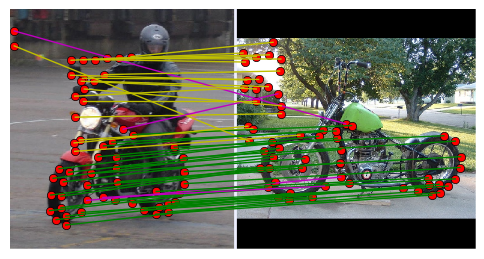

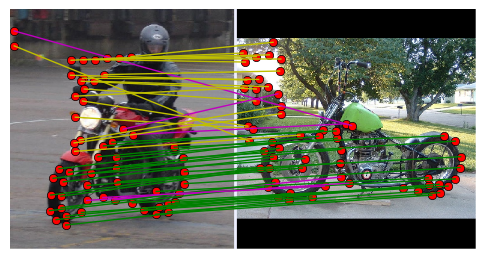

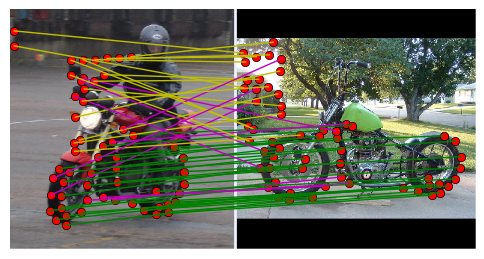

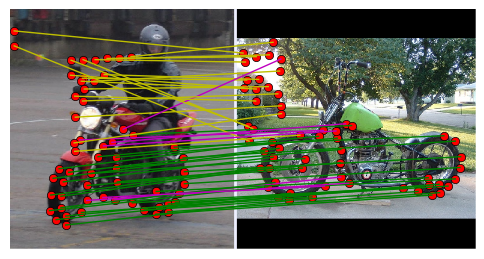

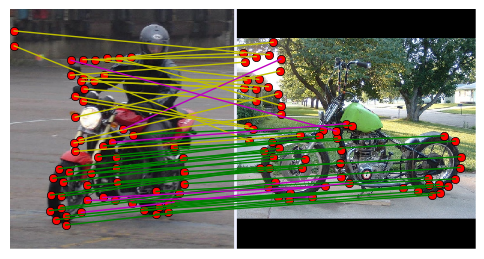

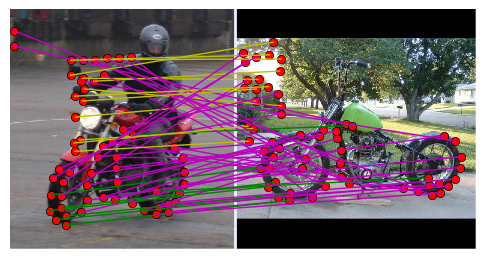

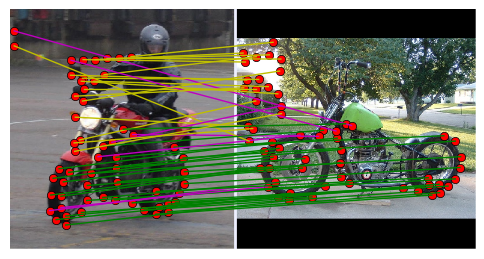

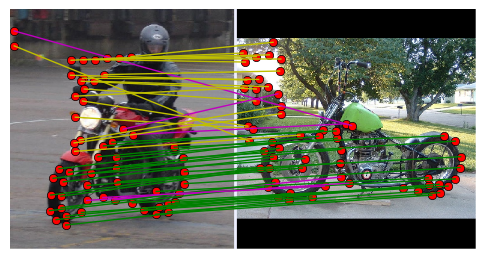

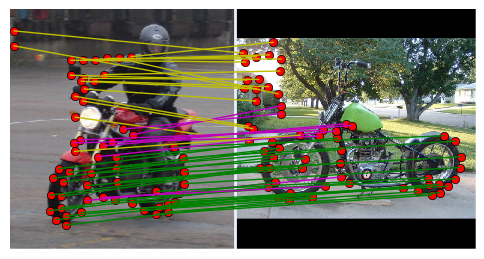

Ours Accuracy 0.677475 Running Time 6.965327 Obj 0.912731
BCA Accuracy 0.434804 Running Time 0.205559 Obj 0.880934
BCA-MP Accuracy 0.501347 Running Time 3.055123 Obj 0.930804
BCA-IPFP Accuracy 0.454420 Running Time 1.440059 Obj 0.913062
HGM Accuracy 0.148844 Running Time 0.003811 Obj 0.227582
RRWHM Accuracy 0.469010 Running Time 9.180470 Obj 0.885954
TM Accuracy 0.424637 Running Time 0.215994 Obj 0.739304
OursPW Accuracy 0.576150 Running Time 9.540681 Obj 0.753118
Ours-BCA Accuracy 0.651286 Running Time 7.222610 Obj 0.985644
FGM Accuracy 0.645428 Running Time 30.340585 Obj 0.876649


In [3]:
#import matlab.engine
import numpy as np;
from sklearn.neighbors import KDTree
import FactorBP as FB
from scipy.spatial import Delaunay
import scipy.io as sio
from Utils import *
import time
from IPython.display import clear_output
import drawMatches as dm
import cPickle as pickle


def ComputeAccuracyPas(decode, gTruth, NofInliers ):
    Ccnt = 0
    for i in range(len(gTruth)):
        if((decode[i] == gTruth[i]) and (gTruth[i] < NofInliers)):
            Ccnt += 1
    return 1.0 * Ccnt / NofInliers

# eng = matlab.engine.start_matlab()
CarData = LoadMotor()

NofAlgorithms = 10
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW', 'Ours-BCA', 'FGM']

MaxNofOus = 20
MeanAcc = np.zeros([MaxNofOus + 1, NofAlgorithms ])
MeanRtime = np.zeros([MaxNofOus + 1, NofAlgorithms])
MeanObj = np.zeros([MaxNofOus + 1, NofAlgorithms])

np.random.seed(123456)
NofInstances = 20
reload(dm)

for NofOus in range(0,MaxNofOus+1):
    Accuracy = np.zeros([NofAlgorithms, NofInstances])
    Rtime = np.zeros([NofAlgorithms, NofInstances])
    Obj = np.zeros([NofAlgorithms, NofInstances])
    for idx in range(1, NofInstances + 1):
        
        car1 = CarData[idx]
        LocalFeature1 = car1['features1']
        LocalFeature2 = car1['features2']
        
        PT1 = LocalFeature1[:, 0:2]
        PT2 = LocalFeature2[:, 0:2]
        
        
        orientation1 = LocalFeature1[:, 8]
        orientation2 = LocalFeature2[:, 8]
        
        GT = car1['gTruth'][0]
        
        NofInliers = len(GT)
        CMaxNofOus = np.min([LocalFeature1.shape[0], LocalFeature2.shape[0]]) - NofInliers
        CNofOus = NofOus
        if(CNofOus > CMaxNofOus):
            CNofOus = CMaxNofOus
        NofNodes = CNofOus + NofInliers
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]
        orientation1 = orientation1[gTruth]
        MG1 = FB.MatchingGraph(PT1[0:NofNodes], orientation1[0:NofNodes])
        MG2 = FB.MatchingGraph(PT2[0:NofNodes], orientation2[0:NofNodes])

        G,MFname = FB.ConstructMatchingModel(MG1, MG2, 'pas', True)
        
        G2 = FB.ConstructMatchingModel(MG1, MG2, 'pas', False)
        Gvis,MFname = FB.ConstructMatchingModel(MG1, MG2, 'pas', True)
        
        

        
        
        
        G.SetVerbose(False)
        
        res1 = FB.BaBSolver(G, 120, 10, 0.005, False)
        res2 = FB.BaBSolver(G2, 600, 5, 0.005, False)

        resFGM = eng.runFGM(MFname,nargout=3)
        resBag = eng.runBcagm(MFname,nargout=3)
        resBagMP = eng.runBcagmQuad1(MFname,1,nargout=3)
        resBagIPFP = eng.runBcagmQuad1(MFname, 2,nargout=3)
        resHGM = eng.runHGM(MFname,nargout=3)
        resRRWHM = eng.runRRWHM(MFname,nargout=3)
        resTM = eng.runTensorMatching(MFname,nargout=3)
        
        print(resFGM)
        
        start_time = time.time()
        ResForBca = sio.loadmat(MFname)
        X0 = np.zeros(NofNodes)
        X0Vec = res1.Decode
        for i in xrange(NofNodes):
            X0[i] = X0Vec[i]
        ResForBca['X0'] = X0
        sio.savemat(MFname, ResForBca)
        resOursBCA = eng.runBcagm(MFname, nargout=3)
        time_dur = time.time() - start_time
        
        
        
        ImageI = idx - 1
        cDecode = FB.intArray(NofNodes)
            
        for i in range(NofNodes):
            cDecode[i] = int(resOursBCA[1][0][i])
        if(res1.Value < Gvis.ComputeObj(cDecode)):
            Accuracy[8][ImageI] = ComputeAccuracyPas(resOursBCA[1][0], gTruth, NofInliers)
            Obj[8][ImageI] = Gvis.ComputeObj(cDecode)
        else:
            Accuracy[8][ImageI] = ComputeAccuracyPas(res1.Decode, gTruth, NofInliers)
            Obj[8][ImageI] = res1.Value


        
        Rtime[8][ImageI] = time_dur + res1.Time
        clear_output()
        #print(resOursBCA[1][0])
        #reload(dm)
        Fname = 'Motor%d_Nous%d_Ours.pdf' % (idx, NofOus)
        dm.drawMatchesWithOutlier(car1['I1'],car1['I2'],PT1[0:NofNodes],PT2[0:NofNodes],res1.Decode, gTruth, NofInliers, Fname)
        
        Fname = 'Motor%d_Nous%d_OursBca.pdf' % (idx, NofOus)
        dm.drawMatchesWithOutlier(car1['I1'],car1['I2'],PT1[0:NofNodes],PT2[0:NofNodes],np.array(resOursBCA[1][0]), gTruth, NofInliers, Fname)


        
        Fname = 'Motor%d_Nous%d_Bca.pdf' % (idx, NofOus)
        dm.drawMatchesWithOutlier(car1['I1'],car1['I2'],PT1[0:NofNodes],PT2[0:NofNodes],np.array(resBag[1][0]), gTruth, NofInliers, Fname)

        Fname = 'Motor%d_Nous%d_BcaIPFP.pdf' % (idx, NofOus)
        dm.drawMatchesWithOutlier(car1['I1'],car1['I2'],PT1[0:NofNodes],PT2[0:NofNodes],np.array(resBagIPFP[1][0]), gTruth, NofInliers, Fname)

        Fname = 'Motor%d_Nous%d_BcaMP.pdf' % (idx, NofOus)
        dm.drawMatchesWithOutlier(car1['I1'],car1['I2'],PT1[0:NofNodes],PT2[0:NofNodes],np.array(resBagMP[1][0]), gTruth, NofInliers, Fname)

        Fname = 'Motor%d_Nous%d_RRWHM.pdf' % (idx, NofOus)
        dm.drawMatchesWithOutlier(car1['I1'],car1['I2'],PT1[0:NofNodes],PT2[0:NofNodes],np.array(resRRWHM[1][0]), gTruth, NofInliers, Fname)

        Fname = 'Motor%d_Nous%d_PW.pdf' % (idx, NofOus)
        dm.drawMatchesWithOutlier(car1['I1'],car1['I2'],PT1[0:NofNodes],PT2[0:NofNodes],res2.Decode, gTruth, NofInliers, Fname)
        
        Fname = 'Motor%d_Nous%d_OursBca.pdf' % (idx, NofOus)
        dm.drawMatchesWithOutlier(car1['I1'],car1['I2'],PT1[0:NofNodes],PT2[0:NofNodes],np.array(resOursBCA[1][0]), gTruth, NofInliers, Fname)

        Fname = 'Motor%d_Nous%d_FGM.pdf' % (idx, NofOus)
        dm.drawMatchesWithOutlier(car1['I1'],car1['I2'],PT1[0:NofNodes],PT2[0:NofNodes],np.array(resFGM[1][0]), gTruth, NofInliers, Fname)


        
        #print(res1.Decode)
        #print(gTruth)
        ImageI = idx - 1
        Accuracy[0][ImageI] = ComputeAccuracyPas(res1.Decode, gTruth, NofInliers)
        Rtime[0][ImageI] = res1.Time
        Obj[0][ImageI] = res1.Value
        
        Accuracy[7][ImageI] = ComputeAccuracyPas(res2.Decode, gTruth, NofInliers)
        Rtime[7][ImageI] = res2.Time
        Obj[7][ImageI] = res2.Value

        Accuracy[1][ImageI] = ComputeAccuracyPas(resBag[1][0], gTruth, NofInliers)
        Rtime[1][ImageI] = resBag[0]
        cDecode = FB.intArray(NofNodes)
        for i in range(NofNodes):
            cDecode[i] = int(resBag[1][0][i])
        Obj[1][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[2][ImageI] = ComputeAccuracyPas(resBagMP[1][0], gTruth, NofInliers)
        Rtime[2][ImageI] = resBagMP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagMP[1][0][i])
        Obj[2][ImageI] = Gvis.ComputeObj(cDecode)
        
        Accuracy[3][ImageI] = ComputeAccuracyPas(resBagIPFP[1][0], gTruth, NofInliers)
        Rtime[3][ImageI] = resBagIPFP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagIPFP[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)
        
        
        Accuracy[4][ImageI] = ComputeAccuracyPas(resHGM[1][0], gTruth, NofInliers)
        Rtime[4][ImageI] = resHGM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resHGM[1][0][i])
        Obj[4][ImageI] = Gvis.ComputeObj(cDecode)
        
        
        Accuracy[5][ImageI] = ComputeAccuracyPas(resRRWHM[1][0], gTruth, NofInliers)
        Rtime[5][ImageI] = resRRWHM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resRRWHM[1][0][i])
        Obj[5][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[6][ImageI] = ComputeAccuracyPas(resTM[1][0], gTruth, NofInliers)
        Rtime[6][ImageI] = resTM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resTM[1][0][i])
        Obj[6][ImageI] = Gvis.ComputeObj(cDecode)
        
        
        Accuracy[9][ImageI] = ComputeAccuracyPas(resFGM[1][0], gTruth, NofInliers)
        Rtime[9][ImageI] = resFGM[0]
        Obj[9][ImageI] = resFGM[2]

        MaxObj = np.max(Obj[:,ImageI])
        #Obj[:,ImageI] /= MaxObj
       
        

        #for ai in xrange(NofAlgorithms):
        #    print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
        #                                                     Accuracy[ai][ImageI],
        #                                                    Rtime[ai][ImageI],
        #                                                    Obj[ai][ImageI]))
        #print('NofOus %d, Finished Frame: %d' % (NofOus,ImageI) )
    FnameSave = 'MotorRes_Nous_%d.pkl' % NofOus
    f = open(FnameSave, "w")
    pickle.dump(Accuracy, f)
    pickle.dump(Obj, f)
    pickle.dump(Rtime, f)






    #Todo Ours-BCA
    for ni in range(Obj.shape[1]):
        MaxObj = np.max(Obj[:,ni])
        Obj[:,ni] /= MaxObj
    
    for ai in xrange(NofAlgorithms):
        MeanAcc[NofOus][ai] = np.mean(Accuracy[ai])
        MeanRtime[NofOus][ai] = np.mean(Rtime[ai])
        MeanObj[NofOus][ai] = np.mean(Obj[ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        np.mean(Accuracy[ai]),
                                                        np.mean(Rtime[ai]),
                                                        np.mean(Obj[ai])))
        #G2.SetVerbose(False)
        #G1.Solve(400)
        #G2.Solve(400)
        #Accurancy[idx - 1] = ComputeAccuracyPas(G1.GetDecode(), gTruth, NofInliers)

        #print('%d %f %f' % (idx, ComputeAccuracyPas(G1.GetDecode(), gTruth, NofInliers),
        #                    ComputeAccuracyPas(G2.GetDecode(), gTruth, NofInliers)))
        #print(res.Time)
        #print(res.Value)

        #AccurancyPW[idx - 1] = ComputeAccuracyPas(G2.GetDecode(), gTruth, NofInliers)

        #print(ComputeAccuracyPas(resPW.Decode, NofInliers))
        #print(resPW.Time)
        #print(resPW.Value)
    #print('HyperAccurancy %f, PairwiseAccurancy %f' % (Accurancy.mean(), AccurancyPW.mean()))

/Users/zhen/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


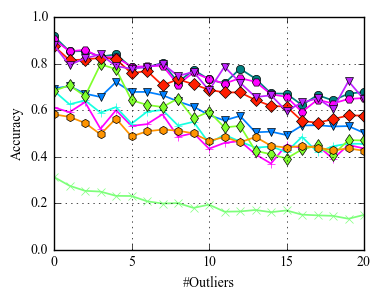

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import pylab
%matplotlib inline

Colors = [[ 0.        ,  0.5        , 0.5        ,  1.        ],
          [ 1.        ,  0.00196078,  1.        ,  1.        ],
          [ 0.        ,  0.50392157,  1.        ,  1.        ],
          [ 0.08538899,  1.        ,  0.88235294,  1.        ],
          [ 0.49019608,  1.        ,  0.47754586,  1.        ],
          [ 0.5       ,  1.        ,  0.17273877,  1.        ],
          [ 1.        ,  0.58169935,  0.        ,  1.        ],
          [ 1.        ,  0.11692084,  0.        ,  1.        ],
          [ 1.        ,  0.        ,  1.        ,  1.        ],
          [ 0.75, 0.134, 1, 1]
         ];
Seq = [0, 8, 1, 2, 3, 4, 5, 6, 7, 9]
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW', 'Ours-BCA', 'FGM']
Markers = ['o', '+', 'v', '+', 'x', 'd', 'h', 'D', 'H', 'v']

figData = pylab.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
ax = pylab.gca()

matplotlib.rc('font',family='Times New Roman')


#plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    pylab.plot(range(0,NofOus+1), MeanAcc[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)
pylab.ylim([0,1.0])
pylab.grid(True)

pylab.ylabel('Accuracy')
pylab.xlabel('#Outliers')


figLegend = pylab.figure(figsize = (11.7,0.4))
pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper center',  ncol=9, shadow=True, fancybox=True)
figData.savefig('Motor_Acc.pdf')
figLegend.savefig("legend.pdf")
figLegend.show()

#plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=9)
#plt.savefig('House_ACC.pdf')    # <-- loses transparency

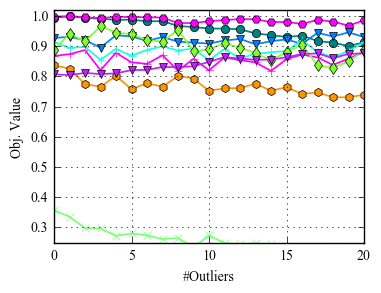

In [17]:



plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in range(NofAlgorithms):
    if(Seq[ai] == 7):
        continue
    plt.plot(range(0,NofOus+1), MeanObj[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)
plt.ylim([0.25,1.02])
plt.ylabel('Obj. Value')
plt.xlabel('#Outliers')
plt.grid(True)
plt.savefig('Motor_Obj.pdf')    # <-- loses transparency

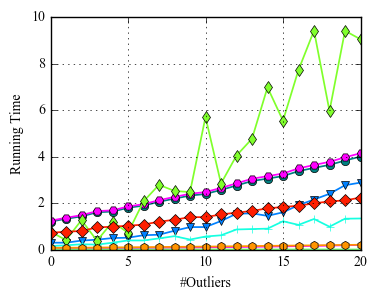

In [5]:
plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(0,NofOus+1), MeanRtime[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)

plt.ylabel('Running Time')
plt.xlabel('#Outliers')

plt.grid(True)
plt.savefig('Motor_Time.pdf')    # <-- loses transparency

In [ ]:
import shelve



filename='shelve_motor.out'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

ERROR shelving: FB
ERROR shelving: G
ERROR shelving: G2
ERROR shelving: Gvis
ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: _sh
ERROR shelving: ax
ERROR shelving: cDecode


In [16]:
MeanObj [:,7] - MeanObj[:,9]

array([-0.0096151 , -0.01428139, -0.02201767, -0.0115074 , -0.01478899,
       -0.03230576, -0.03744752, -0.03937901, -0.044902  , -0.05943515,
       -0.0511178 , -0.07482075, -0.089723  , -0.08163612, -0.08430873,
       -0.09558536, -0.11057723, -0.11943202, -0.12086642, -0.12587572,
       -0.12353079])

In [48]:
import cPickle as pickle
f = open("MotorRes", "w")
pickle.dump(MeanAcc, f)
pickle.dump(MeanObj, f)
pickle.dump(MeanRtime, f)
f.close()




